# Task 3: Customer Segmentation / Clustering

# importing basic libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA


# Read and prepare data

In [67]:
products_df = pd.read_csv('Products.csv')
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Convert dates

In [68]:
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

def create_customer_features():
    # Merge transactions with products
    trans_prod = pd.merge(transactions_df, products_df, on='ProductID')
    
    # Calculate features
    # 1. Total spend by category
    category_spend = trans_prod.pivot_table(
        index='CustomerID',
        columns='Category',
        values='TotalValue',
        aggfunc='sum',
        fill_value=0
    )
    # 2. Transaction metrics
    transaction_metrics = trans_prod.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Number of transactions
        'Quantity': ['sum', 'mean'],  # Total and average items
        'TotalValue': ['sum', 'mean']  # Total spend and average order value
    }).round(2)
    transaction_metrics.columns = ['TransactionCount', 'TotalItems', 
                                 'AvgItemsPerTransaction', 'TotalSpend', 'AvgOrderValue']
    
    # 3. Recency and tenure
    latest_date = transactions_df['TransactionDate'].max()
    last_transaction_date = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    recency = (latest_date - last_transaction_date).dt.days
    
    customers_df['Tenure'] = (latest_date - customers_df['SignupDate']).dt.days
    
    # Combine all features
    customer_features = pd.concat([
        category_spend,
        transaction_metrics,
        recency.rename('Recency'),
        customers_df.set_index('CustomerID')['Tenure']
    ], axis=1)
    
    return customer_features

# Create feature matrix

In [69]:
customer_features = create_customer_features()

# Normalize features

In [70]:
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.fillna(0))
normalized_features_df = pd.DataFrame(
    normalized_features,
    index=customer_features.index,
    columns=customer_features.columns
)

# Find optimal number of clusters using elbow method

In [71]:
inertias = []
db_scores = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertias.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(normalized_features, kmeans.labels_))
    silhouette_scores.append(silhouette_score(normalized_features, kmeans.labels_))


# Plot elbow curve

In [72]:
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

# Inertia plot

Text(0.5, 1.0, 'Elbow Method')

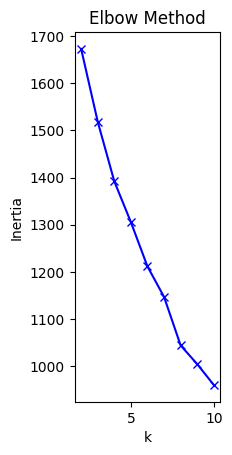

In [73]:
plt.subplot(131)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')


# Davies-Bouldin score plot

Text(0.5, 1.0, 'Davies-Bouldin Score')

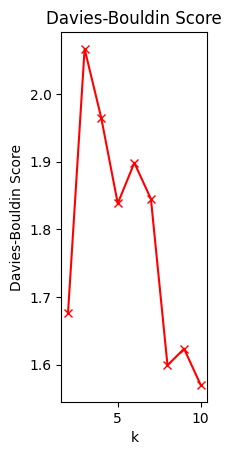

In [74]:
plt.subplot(132)
plt.plot(K, db_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score')


# Silhouette score plot

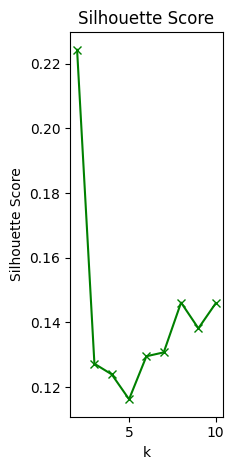

In [75]:
plt.subplot(133)
plt.plot(K, silhouette_scores, 'gx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()


# Find optimal k (minimum Davies-Bouldin score)

In [76]:
optimal_k = K[np.argmin(db_scores)]
print(f"Optimal number of clusters based on Davies-Bouldin score: {optimal_k}")


Optimal number of clusters based on Davies-Bouldin score: 10


# Perform K-means clustering with optimal k

In [77]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(normalized_features)


# Calculate final clustering metrics

In [78]:
final_db_index = davies_bouldin_score(normalized_features, clusters)
final_silhouette = silhouette_score(normalized_features, clusters)


# Visualize clusters using PCA

In [79]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_features)


# Create cluster visualization

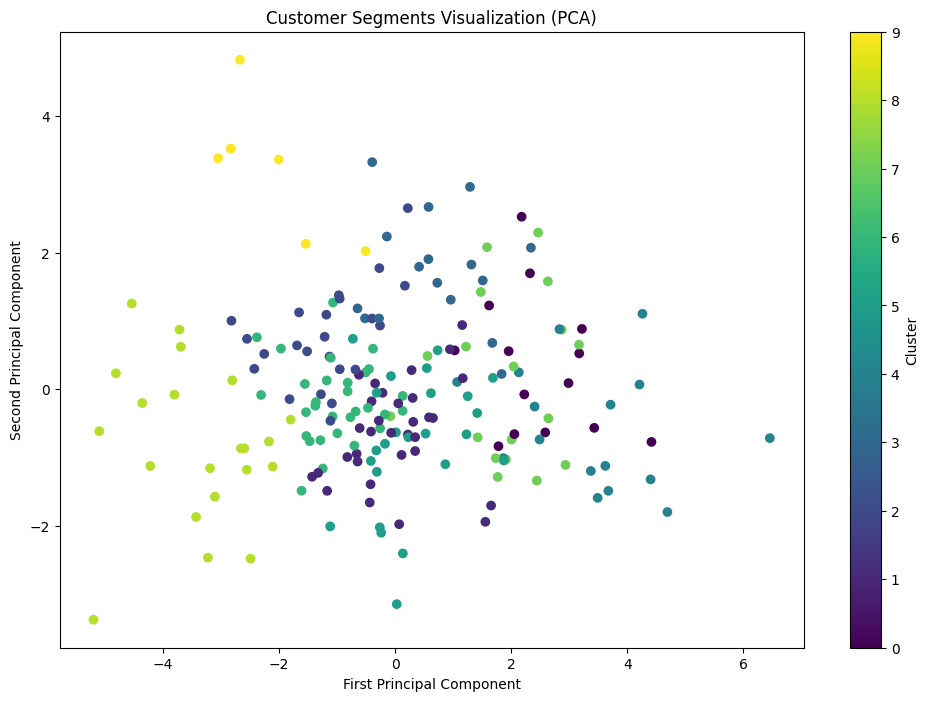

In [80]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                     c=clusters, cmap='viridis')
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()


# Analyze cluster characteristics

In [81]:
cluster_df = customer_features.copy()
cluster_df['Cluster'] = clusters


# Calculate cluster profiles

In [82]:
cluster_profiles = cluster_df.groupby('Cluster').mean().round(2)

# Visualize key metrics by cluster

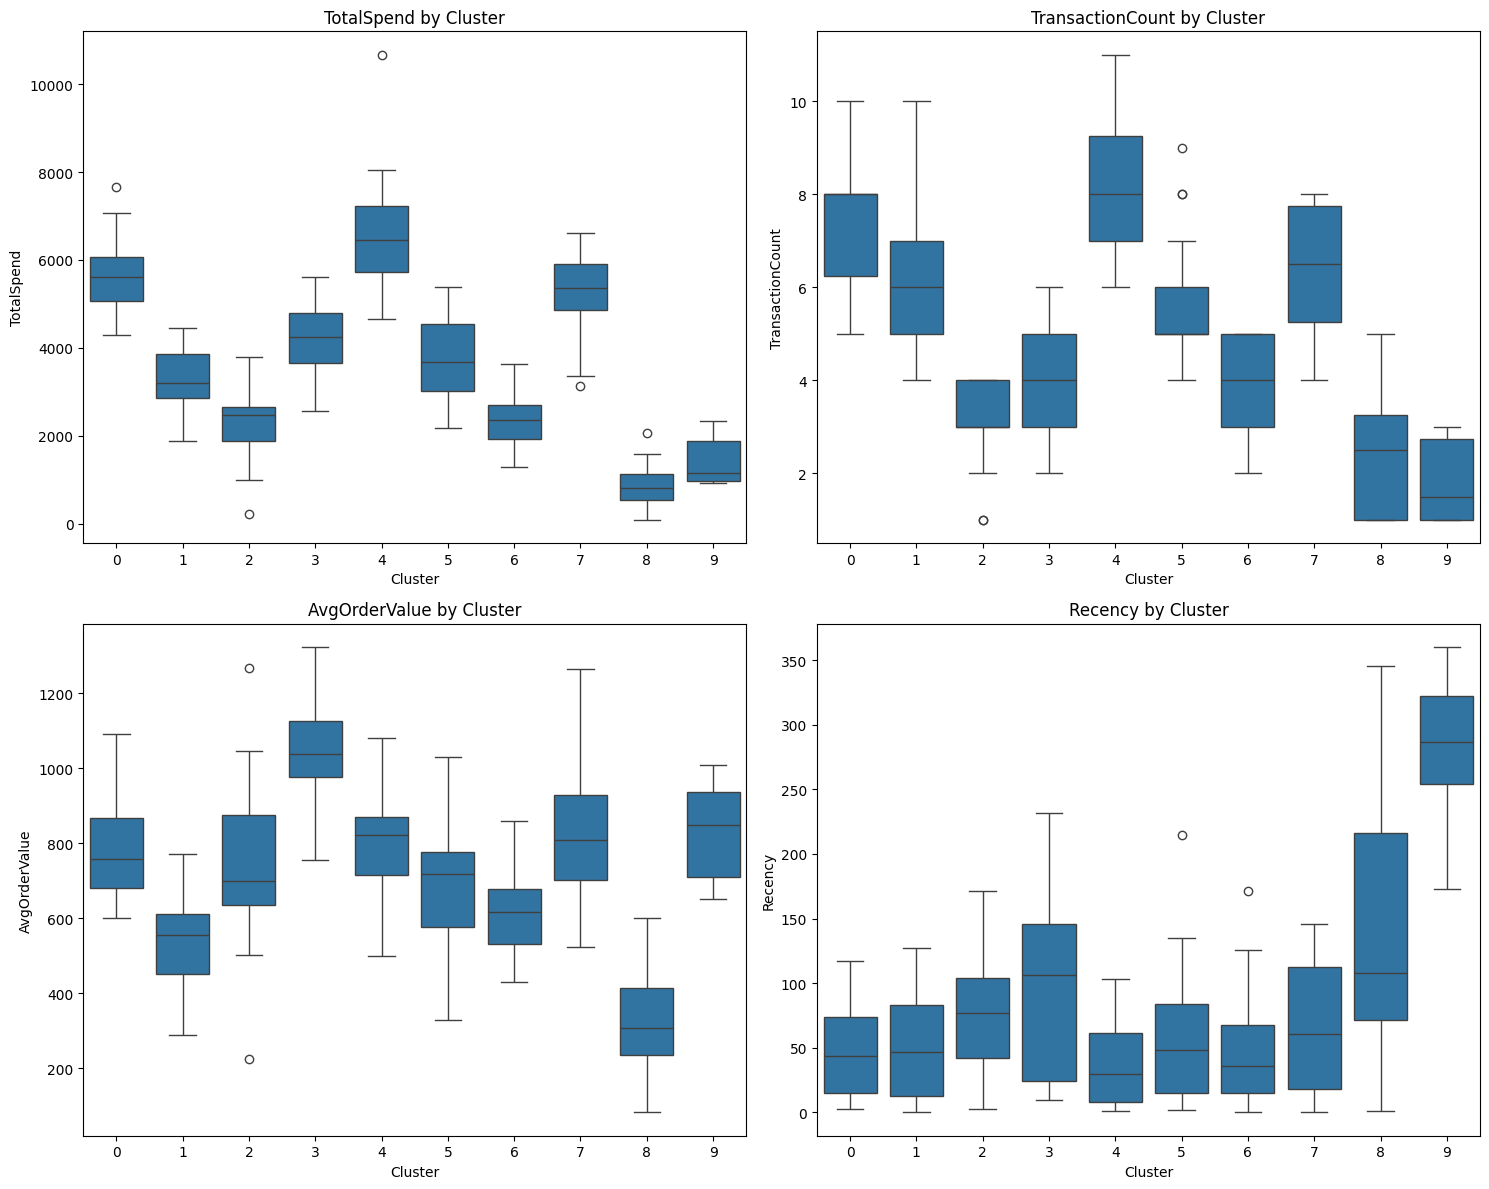

In [83]:
metrics_to_plot = ['TotalSpend', 'TransactionCount', 'AvgOrderValue', 'Recency']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i//2, i%2]
    sns.boxplot(data=cluster_df, x='Cluster', y=metric, ax=ax)
    ax.set_title(f'{metric} by Cluster')
plt.tight_layout()
plt.show()


# Print clustering results

In [84]:
print("\nClustering Results:")
print(f"Number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {final_db_index:.4f}")
print(f"Silhouette Score: {final_silhouette:.4f}")

print("\nCluster Profiles:")
print(cluster_profiles)



Clustering Results:
Number of clusters: 10
Davies-Bouldin Index: 1.5702
Silhouette Score: 0.1459

Cluster Profiles:
           Books  Clothing  Electronics  Home Decor  TransactionCount  \
Cluster                                                                 
0        1162.33    531.43      1566.09     2444.36              7.43   
1         462.07    951.60      1179.31      679.80              6.12   
2         614.80    175.62      1036.73      460.18              3.04   
3         971.45   1649.70       284.12     1261.07              4.06   
4        1852.82   2882.14      1221.33      691.73              8.38   
5        2463.05    363.51       397.79      516.33              5.75   
6         391.40    801.86       318.96      836.67              3.90   
7        1396.67    708.58      2714.92      439.24              6.44   
8         196.73    220.20       214.08      183.41              2.45   
9         304.99    298.75       153.73      670.66              1.83   

      

# Calculate cluster sizes

In [85]:
cluster_sizes = pd.Series(clusters).value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)



Cluster Sizes:
0    14
1    32
2    23
3    16
4    16
5    24
6    30
7    18
8    21
9     6
Name: count, dtype: int64


# Save cluster assignments

In [86]:
cluster_assignments = pd.DataFrame({
    'CustomerID': customer_features.index,
    'Cluster': clusters
})
cluster_assignments.to_csv('customer_segments.csv', index=False)


# Generate cluster descriptions

In [87]:
def describe_cluster(cluster_num):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster_num]
    profile = cluster_profiles.loc[cluster_num]
    
    description = f"\nCluster {cluster_num} ({len(cluster_data)} customers):\n"
    description += f"- Average Total Spend: ${profile['TotalSpend']:,.2f}\n"
    description += f"- Average Transaction Count: {profile['TransactionCount']:.1f}\n"
    description += f"- Average Order Value: ${profile['AvgOrderValue']:,.2f}\n"
    description += f"- Average Recency: {profile['Recency']:.1f} days\n"
    categories = ['Books', 'Electronics', 'Clothing', 'Home Decor']
    top_category = max(categories, key=lambda x: profile[x])
    description += f"- Preferred Category: {top_category}\n"
    
    return description

print("\nCluster Descriptions:")
for i in range(optimal_k):
    print(describe_cluster(i))



Cluster Descriptions:

Cluster 0 (14 customers):
- Average Total Spend: $5,704.20
- Average Transaction Count: 7.4
- Average Order Value: $782.17
- Average Recency: 48.6 days
- Preferred Category: Home Decor


Cluster 1 (32 customers):
- Average Total Spend: $3,272.77
- Average Transaction Count: 6.1
- Average Order Value: $545.52
- Average Recency: 50.7 days
- Preferred Category: Electronics


Cluster 2 (23 customers):
- Average Total Spend: $2,287.33
- Average Transaction Count: 3.0
- Average Order Value: $754.03
- Average Recency: 74.0 days
- Preferred Category: Electronics


Cluster 3 (16 customers):
- Average Total Spend: $4,166.35
- Average Transaction Count: 4.1
- Average Order Value: $1,052.02
- Average Recency: 96.2 days
- Preferred Category: Clothing


Cluster 4 (16 customers):
- Average Total Spend: $6,648.03
- Average Transaction Count: 8.4
- Average Order Value: $806.54
- Average Recency: 39.9 days
- Preferred Category: Clothing


Cluster 5 (24 customers):
- Average Total